In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

### Read the cleaned sqlite file

In [2]:
conn = sqlite3.connect('../8. Amazon_New/final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [4]:
data = final[['Score', 'Time', 'CleanedText']].copy()
data.sort_values('Time', inplace = True)
data.head(10)

,Score,Time,CleanedText
117879,1,939340800,witti littl book make son laugh loud recit car...
117856,1,940809600,rememb see show air televis year ago child sis...
298565,1,944092800,beetlejuic well written movi everyth excel act...
169198,1,944438400,twist rumplestiskin captur film star michael k...
298564,1,946857600,beetlejuic excel funni movi keaton hilari wack...
169259,1,947376000,one movi movi collect fill comedi action whate...
169184,0,948240000,alway enjoy movi funni entertain hesit pick cl...
63292,1,948672000,bought apart infest fruit fli hour trap quot a...
169284,1,951523200,happen say name three time michael keaten star...
298566,1,959990400,get crazi realli imposs today find french vhs ...


### Remember Dataset is not balanced

In [5]:
data['Score'].value_counts()

1    306779
0     57078
Name: Score, dtype: int64

In [6]:
del final

### Separate X and y

In [7]:
X = data['CleanedText']
y = data['Score']

### Time based splitting

In [8]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [9]:
X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape

((254699,), (254699,), (109158,), (109158,))

In [10]:
# Create an object of class CountVectorizer
bow = CountVectorizer()
# Call the fit_transform method on training data
X_train = bow.fit_transform(X_train_raw.values)

In [11]:
X_train.shape

(254699, 63242)

In [12]:
# Call the transform method on the test dataset
X_test = bow.transform(X_test_raw.values)

In [13]:
X_test.shape

(109158, 63242)

### Perform Column Standardization

In [16]:
std = StandardScaler(with_mean=False)
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Cross validation and Hyper Parameter tuning

In [17]:
start = time.time()
# creating list of C
C_values = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for c in C_values:
    # Create an object of the class Logistic Regression with balanced class weights
    clf = LogisticRegression(C = c, class_weight = 'balanced')
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) C is the one for which error is minimum (or accuracy is maximum)
optimal_C = C_values[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_C)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 0.1
Total time in minutes =  221.34980359872182


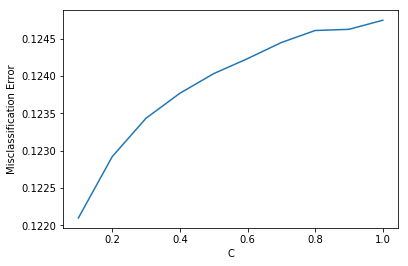

In [18]:
# plot misclassification error vs C
plt.plot(C_values, cv_error)
plt.xlabel('C')
plt.ylabel('Misclassification Error')
plt.show()

In [19]:
clf = LogisticRegression(C = optimal_C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 89.28800454387219


array([[12146,  6920],
       [ 4773, 85319]], dtype=int64)

### Feature Selection

In [26]:
idx = (-abs(clf.coef_)).argsort()[0,:50]
print("Top 50 features:")
for i in idx:
    print(bow.get_feature_names()[i])

Top 50 features:
great
best
love
delici
perfect
good
excel
marmit
muir
nice
glen
disappoint
oomph
favorit
amaz
radius
tasti
worst
awesom
acv
wonder
easi
yum
tast
addict
hook
steadili
terribl
smooth
find
return
beat
thank
http
fantast
aw
happi
glad
horribl
hestit
noir
washabl
yummi
without
even
caveat
year
enjoy
delight
daddi
